# Testing the method on synthetic data

Benjamin Pennell

November 27th, 2025

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import json

with open('config.json') as f:
    d = json.load(f)
    
import sys
import os
folder_a_path = os.path.abspath(os.path.join(os.getcwd(), d["wrapperlitepath"]))
if folder_a_path not in sys.path:
    sys.path.append(folder_a_path)

import GaiamockWrapperLite as gw

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
mdwarfs = Table.read('./data/all_nearby_mdwarfs.fits', format='fits')
working_mdwarfs = mdwarfs[mdwarfs["parallax"] > 5] # cut to 200pc

In [3]:
p_bins = [1,2,3,4.5,8]
m_bins = [0.017,0.045,0.08,0.13,0.2]

## Construct Synthetic Data

We'll start with a uniform distribution across the period, mass bins (which is quite unphysical, since they aren't even equal sized of course), and see if that can be recaptured

and we'll set the binary fraction to 20%, since it should be fairly low

In [ ]:
def get(dset, entry, binary=False):
    working_dset = dset
    if binary:
        working_dset = dset[[d["is_binary"] == True for d in dset]]
    return [w[entry] for w in working_dset]

In [ ]:
### --- ###
def random_angle():
    return float(np.random.rand()*2*np.pi)

def random_inc(): # flat in cos(i) from -1 to 1
    return float(np.acos(2*np.random.rand()-1))

def random_Tp():
    return float(np.random.rand()-0.5) # generally you get Tp in (-0.5,0.5)*period

c_funcs = gw.generate_cfuncs()

def create_synthetic_data(object_count, catalogue, binary_fraction, period_bins, mass_bins, q_lim=(0.05,0.5)):
    # period bins in logperiod, mass bins in solar masses
    binary_count = np.floor(object_count * binary_fraction)
    chosen_objects = np.random.choice(len(catalogue), object_count)
    outdata = []
    pbar = tqdm(total=object_count)
    for i in range(object_count):
        target_object = catalogue[chosen_objects[i]]
        outry = dict()
        outry["ra"], outry["dec"] = float(target_object["ra"]), float(target_object["dec"])
        outry["pmra"], outry["pmdec"] = float(target_object["pmra"]), float(target_object["pmdec"])
        outry["parallax"] = float(target_object["parallax"])
        outry["mass"] = float(target_object["mass_single"])
        outry["phot_g_mean_mag"] =  float(target_object["phot_g_mean_mag"])
        outry["bp_rp"] = float(target_object["bp_rp"])
        outry["is_binary"] = bool(i < binary_count)
        # for single stars, solution type is zero
        outry["solution_type"] = 0
        
        if i < binary_count:
            # binary, actually compute the solution type
            pdx = np.random.choice(len(period_bins)-1)
            period = 10**np.random.uniform(period_bins[pdx], period_bins[pdx+1])
            
            mdx = np.random.choice(len(mass_bins)-1)
            m2 = np.random.uniform(mass_bins[mdx], mass_bins[mdx+1])
            q = m2/outry["mass"]
            while (q < q_lim[0]) or (q_lim[1] < q):
                mdx = np.random.choice(len(mass_bins)-1)
                m2 = np.random.uniform(mass_bins[mdx], mass_bins[mdx+1])
                q = m2/outry["mass"]
            
            outry["period"] = period
            outry["m2"] = m2
            outry["q"] = q
            outry["idx"] = (pdx, mdx)
            outry["ecc"] = 0
            outry["inc"] = random_inc()
            outry["w"], outry["omega"] = random_angle(), random_angle()
            outry["Tp"] = random_Tp()*period
            t = gw.gaiamock.get_gost_one_position(outry["ra"], outry["dec"], data_release="dr3")
            
            solution_type = gw.rapid_solution_type(outry["period"], outry["q"], outry["parallax"], outry["mass"], 
                                                   outry["phot_g_mean_mag"], 1e-10, 0,
                                                   outry["inc"], outry["w"], outry["omega"], outry["Tp"],
                                                   outry["ra"], outry["dec"], outry["pmra"], outry["pmdec"], t, c_funcs)
            outry["solution_type"] = solution_type
        
        outdata.append(outry)
        pbar.update(1)
    
    return outdata

In [ ]:
synthdata = create_synthetic_data(25000, mdwarfs, 0.2, p_bins, m_bins)
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["p_bins"] = p_bins
outdata["meta"]["m_bins"] = m_bins
outdata["meta"]["metaparams"] = f"{0.2} Binary fraction, {25000} objects"
outdata["meta"]["notes"] = "2025.12.06 simplest possible synthetic dataset with a flat distribution to see if things work. Source catalogue: mdwarfs"
outdata["data"] = synthdata
with open('./data/simple_data.json', 'w') as fp:
    json.dump(outdata, fp)

In [9]:
with open('./data/simple_data.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [44]:
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),98.308,1.34,0.132,0.076,0.144
Counts,24577.000,335.00,33.000,19.000,36.000


In [10]:
index_grid = np.zeros((4,4), dtype=int)
for tgt in synthdata:
    if tgt["is_binary"]:
        index_grid[tgt["idx"][0],tgt["idx"][1]] += 1

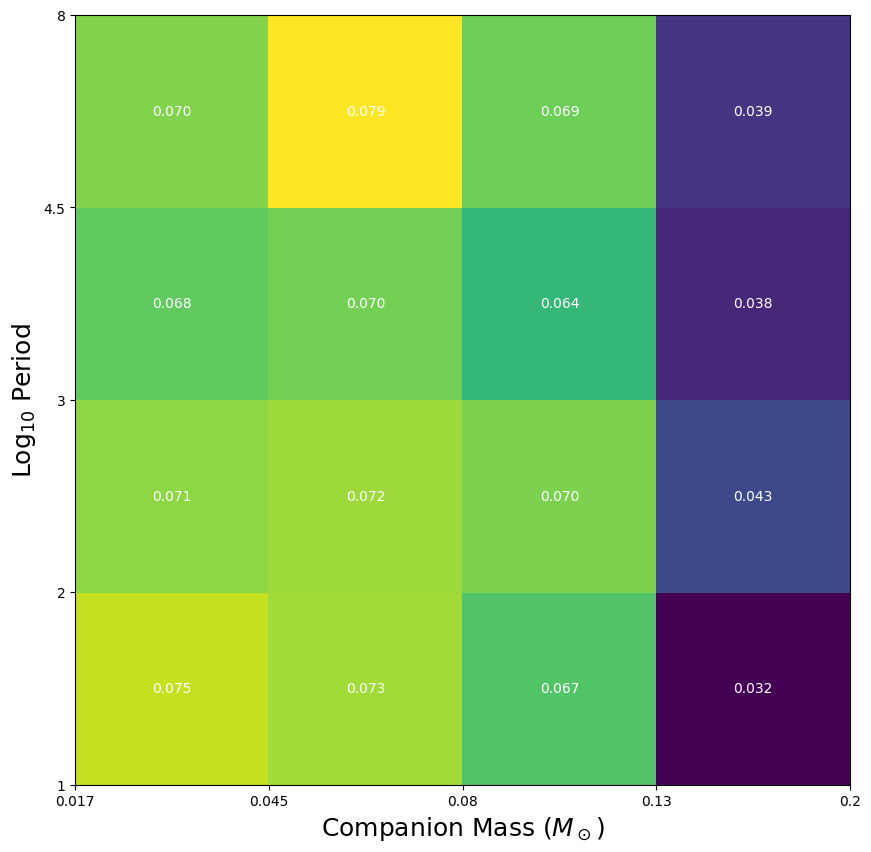

In [12]:
index_grid = index_grid / index_grid.sum()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(index_grid, aspect="auto")

for i in range(index_grid.shape[0]):
    for j in range(index_grid.shape[1]):
        ax.text(j, i, f'{index_grid[i, j]:.3f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, index_grid.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, index_grid.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);

## See if parameters are recovered

In [3]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-02_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/simple_data.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [4]:
synthsampler = Sampler.popsampler(sc_cubes, synthdata[::2], [2,3,4.5], [0.045,0.08,0.13])

In [5]:
synthsampler.constrain_parameters(step_count=1000, nwalkers=50, cutoff=np.exp(-30))

Reducing catalogue...
Computing grids...


  0%|          | 0/12500 [00:00<?, ?it/s]

Running markov chains...


100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s]

Complete!


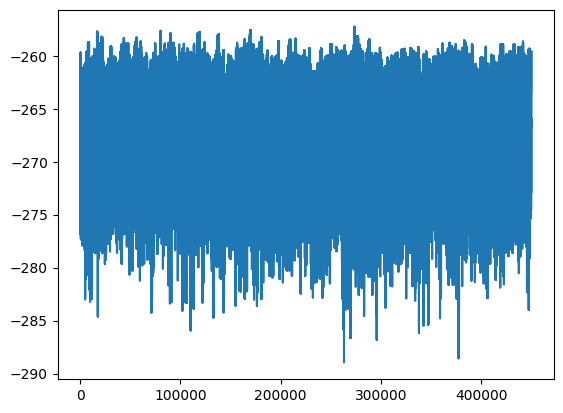

In [50]:
plt.plot(synthsampler.sampler.get_log_prob(discard=1000, flat=True));

In [6]:
chain = synthsampler.sampler.get_chain(discard=500, flat=True)
fb = np.median(chain[:,0])
grid = np.median(chain[:,1:], axis=0)
# grid_probs = np.zeros(16)
# grid_probs[1:] = grid
# grid_probs = grid_probs.reshape(4,4)

logits = grid - np.mean(grid) 
grid_probs = Sampler.softmax(logits)
grid_probs = grid_probs.reshape(4,4)

In [97]:
grid_arr = chain[:,1:]
logit_arr = chain[:,1:] - np.mean(chain[:,1:], axis=1)[:,None]
grid_prob_arr = np.array([Sampler.softmax(l) for l in logit_arr])

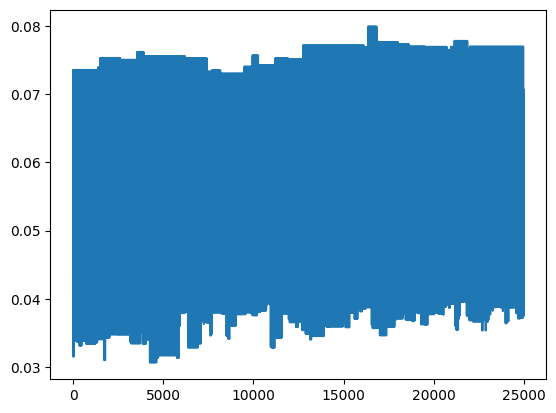

In [8]:
plt.plot(chain[:,0]);

In [90]:
np.round(grid, 2)

array([ 3.42,  3.32, -1.28, -4.36,  0.6 , -0.55,  0.52, -1.66,  2.24,
       -1.7 , -0.58, -2.43,  3.41,  3.41,  3.42])

In [91]:
np.round(grid_probs, 2)

array([[0.16, 0.14, 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.  ],
       [0.05, 0.  , 0.  , 0.  ],
       [0.15, 0.15, 0.16, 0.16]])

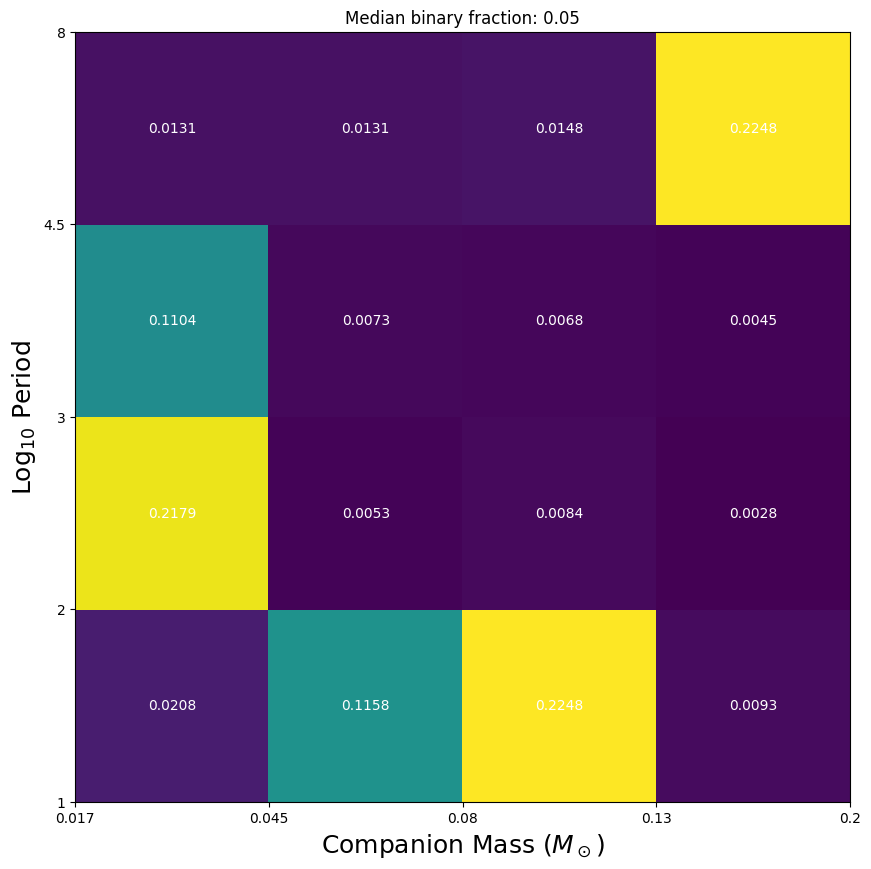

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(grid_probs, aspect="auto")

for i in range(grid_probs.shape[0]):
    for j in range(grid_probs.shape[1]):
        ax.text(j, i, f'{grid_probs[i, j]:.4f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, grid_probs.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, grid_probs.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);
ax.set_title(f"Median binary fraction: {fb:.2f}");

In [10]:
working_catalogue = []
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i, target_object in enumerate(synthdata):
    # save just parallax and mass for grid conversion
    reduced_object = {
        "parallax": target_object["parallax"],
        "mass": target_object["mass"],
        "soltype_index": [0,5,7,9,12].index(target_object["solution_type"])
    }
    working_catalogue.append(reduced_object)
    
    # save just solution type for use at inference
    soltypes[i] = target_object["solution_type"] 
working_catalogue = np.array(working_catalogue)

# precompute the q-L mappings for all the objects
print("Computing grids...")
grids = np.array(Sampler.compute_grids(working_catalogue, sc_cubes, [2,3,4.5], [0.045,0.08,0.13]))

Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

In [15]:
ind = 35

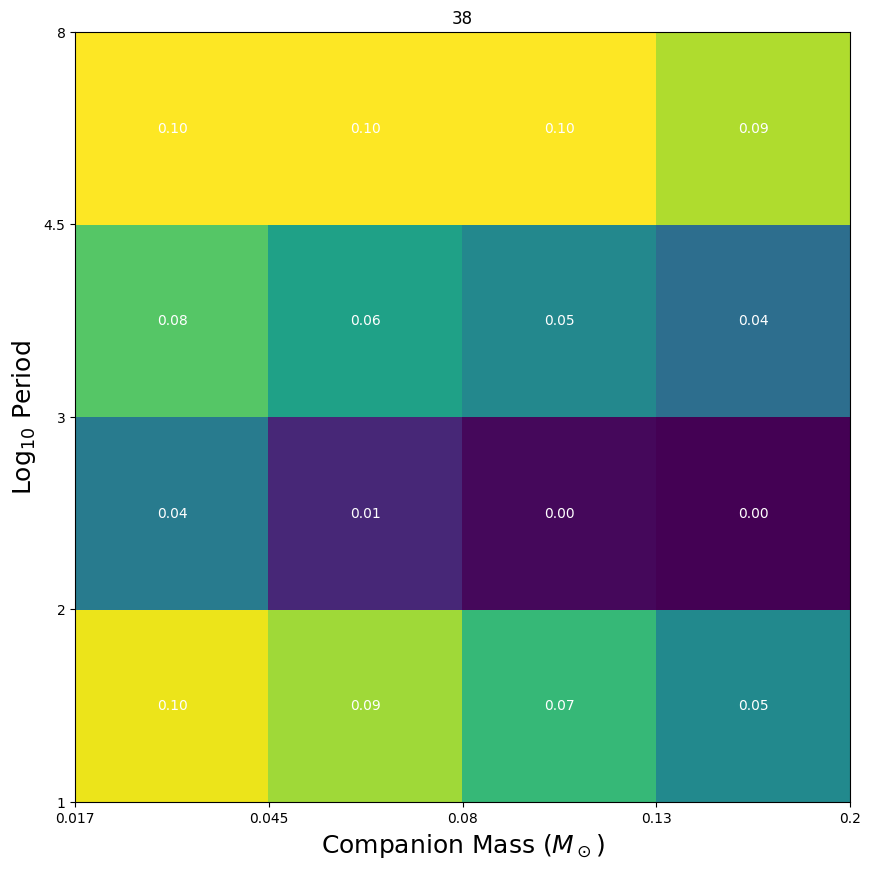

In [73]:
ind+=1
working_grid = np.mean(grids, axis=0).reshape(4,4)#*grid_probs
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(working_grid, aspect="auto")

for i in range(working_grid.shape[0]):
    for j in range(working_grid.shape[1]):
        ax.text(j, i, f'{working_grid[i, j]/working_grid.sum():.2f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, working_grid.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, working_grid.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);
ax.set_title(ind);

In [9]:
pbins, mbins = [1,2,3,4,5,7,8], [0.017,0.03,0.05,0.08,0.11,0.15,0.2]

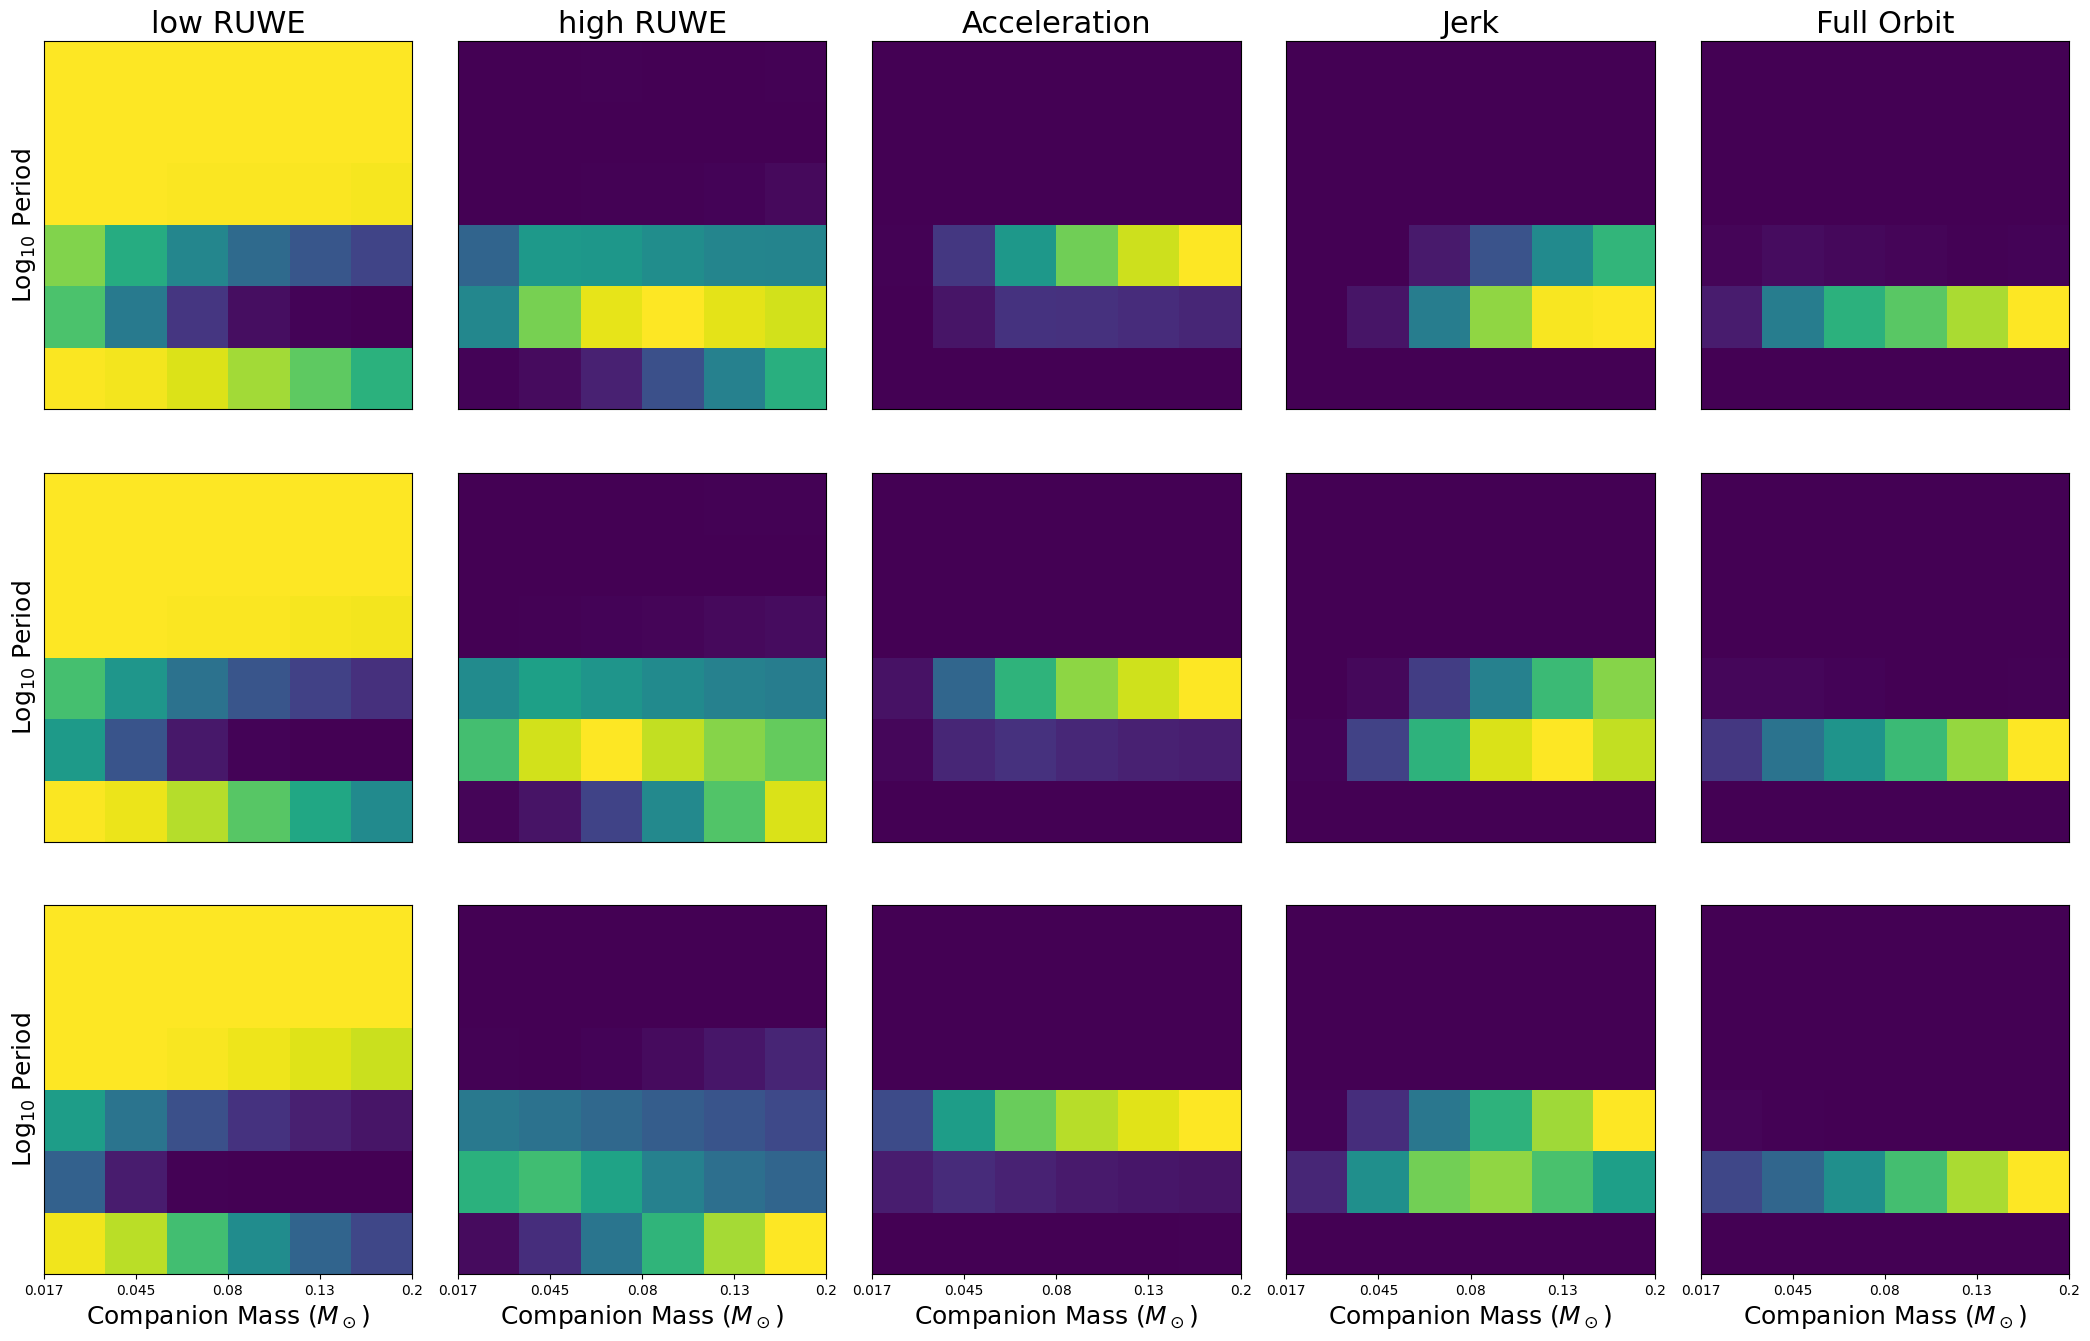

In [42]:
titles = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
plxs = [4, 5.3, 8]
fig, axs = plt.subplots(3,5, figsize=(21,14), sharey=True)

for i in range(5):
    for j in range(3):
        target_object = {
            "parallax": plxs[j],
            "mass": 0.35,
            "soltype_index": i
        }
        reduced_cube = Sampler.compute_grid(target_object, sc_cubes, [2,3,4,5,7], [0.03,0.05,0.08,0.11,0.15])
        working_object = reduced_cube
        axs[j,i].imshow(working_object, aspect="equal")

        # for i in range(working_object.shape[0]):
        #     for j in range(working_object.shape[1]):
        #         ax.text(j, i, f'{working_object[i, j]:.2f}', ha='center', va='center', color='white')
        if j == 0:
            axs[j,i].set_title(titles[i], fontsize=22);
        
        if j == 2:
            axs[j,i].set_xticks(np.linspace(-0.5, working_object.shape[0]-0.5, len(m_bins)))
            axs[j,i].set_xticklabels(m_bins);
            axs[j,i].set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
        else:
            axs[j,i].set_xticks([])
        
        if i == 0:
            axs[j,i].set_yticks(np.linspace(-0.5, working_object.shape[1]-0.5, len(p_bins)))
            axs[j,i].set_yticklabels(p_bins);
            axs[j,i].set_ylabel(r"Log$_{10}$ Period", fontsize=18);
        else:
            axs[j,i].set_yticks([])
            
        axs[j,i].invert_yaxis();

plt.tight_layout()

## BINARITY

### Synthetic Data

In [6]:
def get(dset, entry, binary=False):
    working_dset = dset
    if binary:
        working_dset = dset[[d["is_binary"] == True for d in dset]]
    return [w[entry] for w in working_dset]

In [101]:
### --- ###
def random_angle():
    return float(np.random.rand()*2*np.pi)

def random_inc(): # flat in cos(i) from -1 to 1
    return float(np.acos(2*np.random.rand()-1))

def random_Tp():
    return float(np.random.rand()-0.5) # generally you get Tp in (-0.5,0.5)*period

c_funcs = gw.generate_cfuncs()

def create_synthetic_data(object_count, catalogue, binary_fraction, m_lim=(0.017,0.2)):
    # period bins in logperiod, mass bins in solar masses
    binary_count = np.floor(object_count * binary_fraction)
    chosen_objects = np.random.choice(len(catalogue), object_count)
    outdata = []
    pbar = tqdm(total=object_count)
    for i in range(object_count):
        target_object = catalogue[chosen_objects[i]]
        outry = dict()
        outry["ra"], outry["dec"] = float(target_object["ra"]), float(target_object["dec"])
        outry["pmra"], outry["pmdec"] = float(target_object["pmra"]), float(target_object["pmdec"])
        outry["parallax"] = float(target_object["parallax"])
        outry["mass"] = float(target_object["mass_single"])
        outry["phot_g_mean_mag"] = 11.5 #float(target_object["phot_g_mean_mag"])
        outry["bp_rp"] = float(target_object["bp_rp"])
        outry["is_binary"] = bool(i < binary_count)
        # for single stars, solution type is zero
        outry["solution_type"] = 0
        
        if i < binary_count:
            # binary, actually compute the solution type
            period = 10**np.random.uniform(1,5)
            
            q = np.random.uniform(0.05,0.5)
            m2 = q*outry["mass"]
            while (m2 < m_lim[0]) or (m_lim[1] < m2):
                q = np.random.uniform(0.05,0.5)
                m2 = q*outry["mass"]
            
            outry["period"] = period
            outry["m2"] = m2
            outry["q"] = q
            outry["ecc"] = 0
            outry["inc"] = random_inc()
            outry["w"], outry["omega"] = random_angle(), random_angle()
            outry["Tp"] = random_Tp()*period
            t = gw.gaiamock.get_gost_one_position(outry["ra"], outry["dec"], data_release="dr3")
            
            solution_type = gw.rapid_solution_type(outry["period"], outry["q"], outry["parallax"], outry["mass"], 
                                                   outry["phot_g_mean_mag"], 1e-10, 0,
                                                   outry["inc"], outry["w"], outry["omega"], outry["Tp"],
                                                   outry["ra"], outry["dec"], outry["pmra"], outry["pmdec"], t, c_funcs)
            outry["solution_type"] = solution_type
        
        outdata.append(outry)
        pbar.update(1)
    
    return outdata

In [102]:
synthdata = create_synthetic_data(5000, working_mdwarfs, 0.2)
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.2} Binary fraction, {5000} objects"
outdata["meta"]["notes"] = "2025.12.09 flat in T and q, not in T/q bins. only T \in (1,5). Source catalogue: mdwarfs cut to 200pc"
outdata["data"] = synthdata
with open('./data/binarity_testing_data.json', 'w') as fp:
    json.dump(outdata, fp)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [103]:
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),89.56,5.18,2.36,1.48,1.42
Counts,4478.00,259.00,118.00,74.00,71.00


In [104]:
ps = []
m2s = []
qs = []
sols = []
ls = []
for target_object in synthdata:
    if target_object["is_binary"]:
        ps.append(np.log10(target_object["period"]))
        m2s.append(target_object["m2"])
        qs.append(target_object["q"])
        ls.append(Sampler.calculate_orbit_parameter(target_object["mass"], target_object["q"], target_object["parallax"]))
        sols.append(target_object["solution_type"])

ps, m2s, qs, sols, ls = np.array(ps), np.array(m2s), np.array(qs), np.array(sols), np.array(ls)

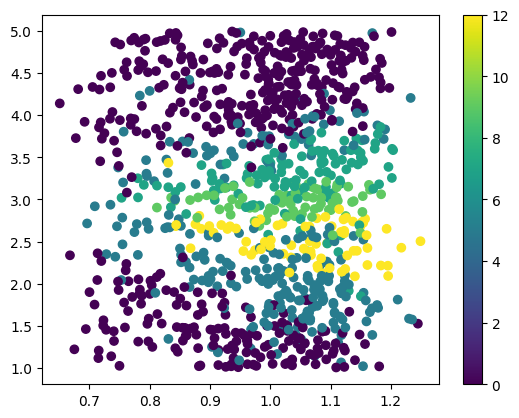

In [105]:
cb = plt.scatter(ls**(1/4), ps, c=sols);
plt.colorbar(cb);

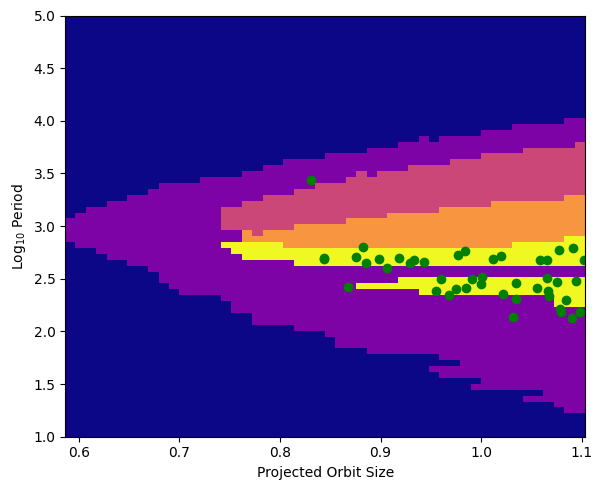

In [111]:
fig, ax = plt.subplots(1,1, figsize=(6,5));
plxs = list(sc_cubes["cube"].keys())
ax.set_ylabel(r"$\text{Log}_{10}$ Period");
lams = sc_cubes["meta"]["lambdas"][1]**(1/4)
xrange = np.array((lams[0], lams[-1]))
logps = np.log10(sc_cubes["meta"]["periods"])
yrange = (logps[-1], logps[0])
extent = [*xrange, *yrange]
extent = [float(e) for e in extent]

type_mask = sols == 12
cb = ax.scatter(ls[type_mask]**(1/4), ps[type_mask], c="green");
colorcube = np.argmax((sc_cubes["data"][plxs[1]] + sc_cubes["data"][plxs[2]])/2, axis=2)
ax.imshow(colorcube, extent=extent, aspect="auto", cmap="plasma");
ax.invert_yaxis()
ax.set_xlabel("Projected Orbit Size");
fig.tight_layout()
ax.set_ylim(top=5);

### Constraining

In [113]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-02_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/binarity_testing_data.json', 'r') as fp:
    synthdata = np.array(json.load(fp)["data"])

In [114]:
model_cube = Sampler.create_model_cube((15,15), 5, 3, p_range=(1,5))

In [115]:
synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)

In [120]:
fbs, likelihoods = synthsampler.binarity(resolution=1000, p_range=(1,5))

Reducing catalogue...
Computing grids...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
%matplotlib inline
plt.clf()

In [118]:
%matplotlib ipympl

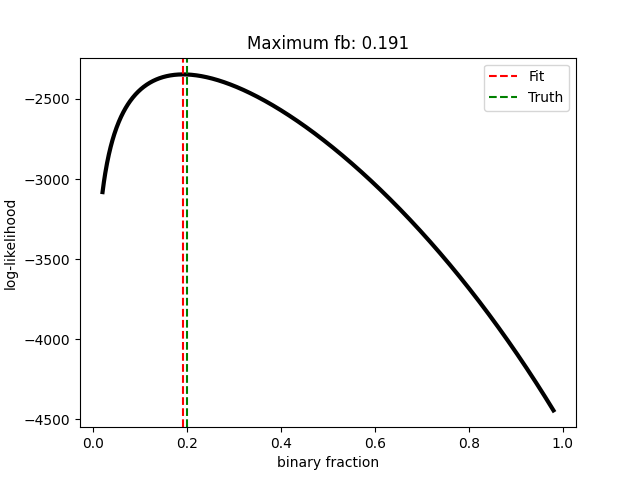

In [122]:
plt.clf();
max_likelihood_fb = fbs[np.argmax(likelihoods)]
plt.plot(fbs, likelihoods, c="black", linewidth=3);
plt.axvline(x=max_likelihood_fb, c="red", linestyle="--", label="Fit");
plt.axvline(x=0.2, c="green", linestyle="--", label="Truth")
plt.xlabel("binary fraction");
plt.ylabel("log-likelihood");
plt.title(f"Maximum fb: {max_likelihood_fb:.3f}");
plt.legend();
plt.show();

In [10]:
p_range, q_range = (1,5), (0.05,0.5)
print("Reducing catalogue...")
working_catalogue = []
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i, target_object in enumerate(synthdata):
    # save just parallax and mass for grid conversion
    reduced_object = {
        "parallax": target_object["parallax"],
        "mass": target_object["mass"],
        "soltype_index": [0,5,7,9,12].index(target_object["solution_type"])
    }
    working_catalogue.append(reduced_object)
    
    # save just solution type for use at inference
    soltypes[i] = target_object["solution_type"] 
working_catalogue = np.array(working_catalogue)

# precompute the q-L mappings for all the objects
print("Computing grids...")
p_boundaries = np.linspace(*p_range, model_cube.shape[0]+1)[1:-1]
q_boundaries = np.linspace(*q_range, model_cube.shape[1]+1)[1:-1]
grids = np.array(Sampler.compute_grids(working_catalogue, sc_cubes, p_boundaries, q_boundaries, q_space=True))

Reducing catalogue...
Computing grids...


  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
i = 2

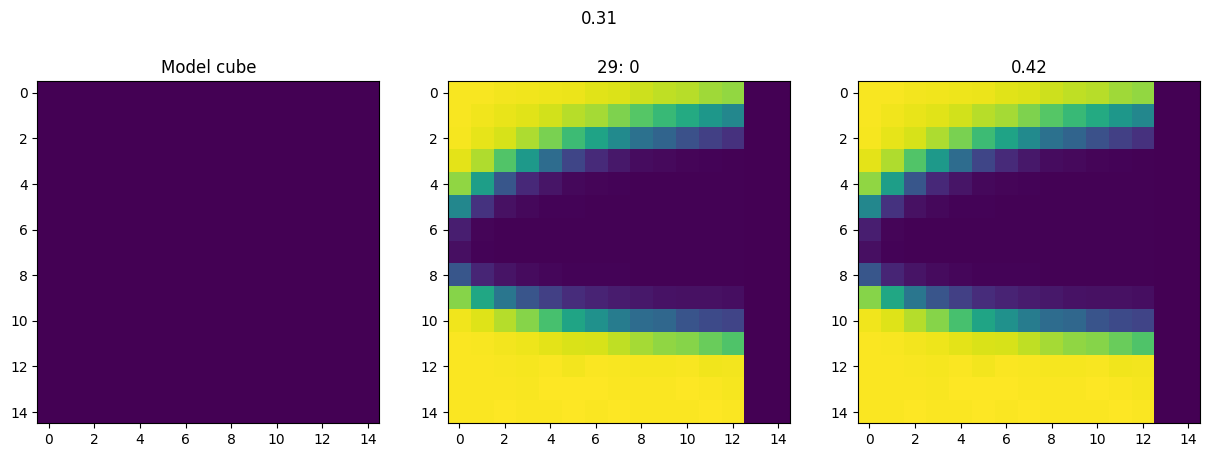

In [48]:
i += 1
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].imshow(model_cube);
axs[0].set_title("Model cube");

axs[1].imshow(grids[i].reshape(15,15));
axs[1].set_title(f"{i}: {soltypes[i]}");

mult_cubes = model_cube * grids[i].reshape(15,15)
axs[2].imshow(mult_cubes);
axs[2].set_title(f"{mult_cubes.sum():.2f}");

tmass = synthdata[i]["mass"]
plt.suptitle(f"{tmass:.2f}");

In [35]:
fb = 0.2
# compute individual solution chance
dot_values = fb * np.dot(grids, model_cube.ravel())

# For solution_type == 0, add single star component (1 - fb)
#dot_values[soltypes == 0] += (1 - fb)

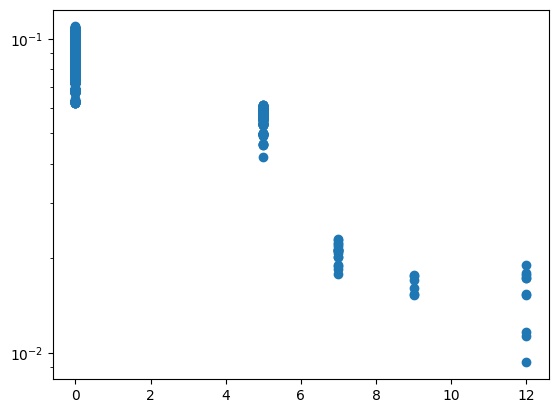

In [36]:
plt.scatter(soltypes, dot_values);
plt.yscale("log")

In [37]:
(np.sum(grids[i].reshape(15,15))/225)

np.float64(0.22901543116219664)